In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.mscalev4
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [2]:
# generate waveforms

0.7371407751049505 1.2246467991473532e-16 -0.7853981633974483


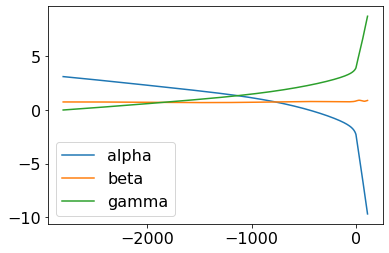

In [3]:
params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=20,
    approximant=lalsim.SEOBNRv4P,
    S1x=0.5,
    S1y=0.5,
    S2x=0.5,
    S2y=0.5,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=None, t_max=110)

thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

In [4]:
# preprocess waveforms

In [5]:
# scale times
times_scaler = MinMaxScaler(feature_range=(-1,0))
X_train = times_scaler.fit_transform(times[:,np.newaxis])

In [6]:
X_train

array([[-1.00000000e+00],
       [-9.99858297e-01],
       [-9.99716593e-01],
       ...,
       [-2.83406547e-04],
       [-1.41703273e-04],
       [ 4.16333634e-17]])

In [7]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
y_train = np.column_stack(
    (wr.hlms[(2,2)].real/scale_22,wr.hlms[(2,2)].imag/scale_22)
)

0.20685853666243229


In [8]:
y_train

array([[ 6.57477832e-02,  3.06915770e-01],
       [ 7.13880617e-02,  3.05657980e-01],
       [ 7.70042697e-02,  3.04296554e-01],
       ...,
       [-1.95726977e-04, -1.58305631e-04],
       [-2.17239582e-04, -1.09169264e-04],
       [-2.27443908e-04, -5.83753750e-05]])

In [9]:
# fit waveforms

In [45]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None):

#     scales = [1,10,50]
    scales = [1,10,50,100]
    # scales = [1, 2, 5, 10, 20, 50, 100, 500]
    n_scales = len(scales)
    n_blocks = [1] * n_scales
    layers_per_block = 3
    units = [128] * n_scales
    activation = "relu"
    scale_activation="s2relu"


    model_params_dict = dict(
        input_shape=1,
        output_shape=y_train.shape[1],
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    model = wispy.mscalev5.build_model(**model_params_dict)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9, monitor='loss')
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [46]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [47]:
%%time
history, model = run_model(X_train_fit, y_train_fit, epochs=1000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit))

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

CPU times: user 4min 57s, sys: 1min 47s, total: 6min 45s
Wall time: 1min 38s


In [48]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

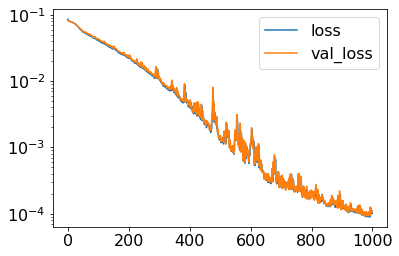

In [49]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")

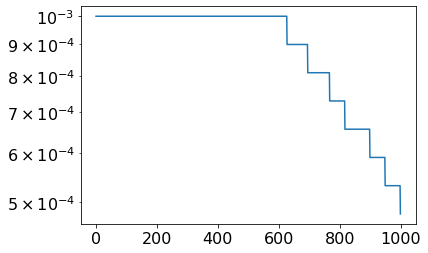

In [50]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

In [89]:
X_train.shape

(7058, 1)

In [90]:
y_train.shape

(7058, 2)

In [51]:
yhat = model.predict(X_train)

In [52]:
yhat.shape

(7058, 2)

In [53]:
X_train.shape

(7058, 1)

(-0.2, 0.1)

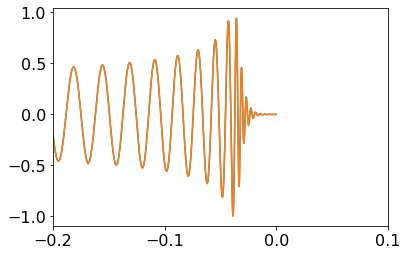

In [54]:
plt.figure()
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
plt.xlim(-0.2, 0.1)

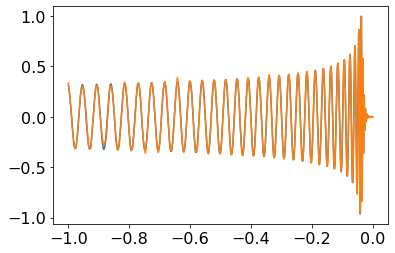

In [55]:
plt.figure()
plt.plot(X_train, y_train[:,1])
plt.plot(X_train, yhat[:,1])
# plt.xlim(-0.2, 0.1)

In [56]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_6 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_7 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_8 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
____________________________________________________________________________________________

# run plain model

In [68]:
def run_plain_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None,
                    num_hidden_layers=3,
                    units=128
                   ):
    
    input_shape = X_train.shape[1]
    output_shape = y_train.shape[1]
    
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(units, activation="relu")(input_layer)
    
    for i in range(num_hidden_layers):
        x = tf.keras.layers.Dense(units, activation="relu")(x)
    
    x = tf.keras.layers.Dense(output_shape, activation="linear")(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9, monitor='loss')
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [79]:
plain_history, plain_model = run_plain_model(X_train_fit, y_train_fit, epochs=2000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit),
                                             num_hidden_layers=3,
                                             units=256)

Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

In [80]:
plain_history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

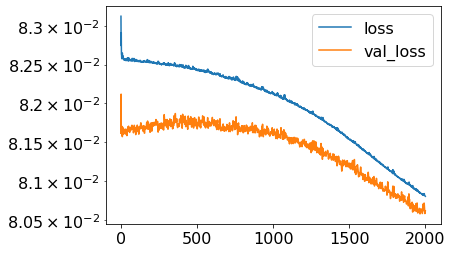

In [81]:
plt.figure()
plt.plot(plain_history.history["loss"], label='loss')
plt.plot(plain_history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")

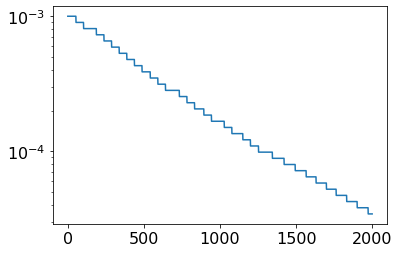

In [82]:
plt.figure()
plt.plot(plain_history.history['lr'])
plt.yscale('log')

In [83]:
plain_yhat = plain_model.predict(X_train)

In [84]:
plain_yhat.shape

(7058, 2)

In [85]:
X_train.shape

(7058, 1)

(-0.2, 0.1)

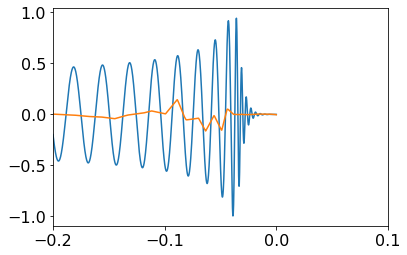

In [86]:
plt.figure()
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, plain_yhat[:,0])
plt.xlim(-0.2, 0.1)

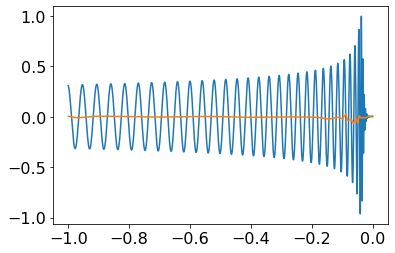

In [87]:
plt.figure()
plt.plot(X_train, y_train[:,1])
plt.plot(X_train, plain_yhat[:,1])
# plt.xlim(-0.2, 0.1)

In [88]:
plain_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_57 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_58 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 514       
Total params: 198,402
Trainable params: 198,402
Non-trainable params: 0
_____________________________________________________